# Importing Dependencies

In [ ]:
#In case, you wish to run code and catboost is not installed then uncomment this cell
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Model Comparison Function

In [ ]:
def modelComparison(data, dataset_type, encoding = 0, scaling = 0, test = 0.2):
  print("For "+dataset_type)
  #Data pre-processing
  cat_cols = [x for x in data.columns.tolist() if data[x].dtype == 'O']
  bool_dict = {}
  cat_dict = {}
  for col in cat_cols:
    temp = list(data[col].unique())
    if (len(temp) == 2):
      bool_dict[col] = temp
    else:
      cat_dict[col] = temp
  print("Boolean-category columns:", bool_dict)
  print("Multi-category columns:", cat_dict)
  #Boolean-Category Columns
  for col in list(bool_dict.keys()):
    for idx, val in enumerate(bool_dict[col]):
      data[col].replace(to_replace = val, value = idx, inplace = True)
  #Multi-Category Columns
  #One-hot encoding
  if (encoding == 0):
    for col in list(cat_dict.keys()):
      data[col] = data[col].apply(lambda x: col+'_'+ x)
      temp = list(data[col].unique())
      for t in temp:
        data[t] = 0
        data.loc[list(data[data[col] == t].index), t] = 1
      data = data.drop(columns = [col])
  #Label encoding
  elif (encoding == 1):
    for col in list(cat_dict.keys()):
      for idx, val in enumerate(cat_dict[col]):
        data[col].replace(to_replace = val, value = idx, inplace = True)
  else:
    print("Input 0 or 1 for encoding")
    return
  
  #Class Label Calculation
  letterG1 = [0]*data.shape[0]
  letterG2 = [0]*data.shape[0]
  letterG3 = [0]*data.shape[0]
  for idx, row in data.iterrows():
    if row['G1'] >= 18:
      letterG1[idx] = 4
    elif row['G1'] >= 16:
      letterG1[idx] = 3
    elif row['G1'] >= 14:
      letterG1[idx] = 2
    elif row['G1'] >= 12:
      letterG1[idx] = 1
    
    if row['G2'] >= 18:
      letterG2[idx] = 4
    elif row['G2'] >= 16:
      letterG2[idx] = 3
    elif row['G2'] >= 14:
      letterG2[idx] = 2
    elif row['G2'] >= 12:
      letterG2[idx] = 1
    
    if row['G3'] >= 18:
      letterG3[idx] = 4
    elif row['G3'] >= 16:
      letterG3[idx] = 3
    elif row['G3'] >= 14:
      letterG3[idx] = 2
    elif row['G3'] >= 12:
      letterG3[idx] = 1
  data = data.drop(columns = ['G1', 'G2', 'G3'])

  #Data Scaling
  #MinMax Scaling
  if (scaling == 0):
    scaler = MinMaxScaler()
    scaledData = scaler.fit_transform(data)
    scaledData = pd.DataFrame(scaledData, columns=data.columns.tolist())
    print("MinMax Scaled Data Shape:", scaledData.shape)
  #Standard Scaling
  elif (scaling == 1):
    scaler = MinMaxScaler()
    scaledData = scaler.fit_transform(data)
    scaledData = pd.DataFrame(scaledData, columns=data.columns.tolist())
    print("Standard Scaled Data Shape:", scaledData.shape)
  #Unscaled
  elif (scaling == 2):
    scaledData = data.copy()
    print("Un-Scaled Data Shape:", scaledData.shape)
  else:
    print("Input 0, 1 or 2 for scaling")
    return

  #Creating Train, Validation and Test splits
  X_temp, X_test, y_temp, y_test = train_test_split(scaledData, letterG3, test_size=test, random_state=19)
  X_train, X_cross, y_train, y_cross = train_test_split(X_temp, y_temp, test_size=test, random_state=19)
  print("Train Data:", X_train.shape, len(y_train))
  print("Validation Data:", X_cross.shape, len(y_cross))
  print("Test Data:", X_test.shape, len(y_test))
  #Initializing cross-validation function
  cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
  #13 Models Comparison with various hyper-parameter tuning
  best_models_list, best_train_accuracy, best_test_accuracy, misclass = [], [], [], []
  #Logistic Regression
  clf = LogisticRegression()
  parameters = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'max_iter': [750, 1000, 2500, 5000]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Logistic Regression Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Stochastic Gradient Decsent Classifier
  clf = SGDClassifier()
  parameters = {'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 'eta0': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Stochastic Gradient Decsent Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Decision Tree Classifier
  clf = DecisionTreeClassifier()
  parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Decision Tree Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Random Forest Classifier
  clf = RandomForestClassifier()
  parameters = {'criterion': ['gini', 'entropy'], 'n_estimators': [10, 25, 50, 100, 200, 500]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Random Forest Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #AdaBoost Classifier
  clf = AdaBoostClassifier()
  parameters = {'n_estimators': [10, 25, 50, 100, 200, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best AdaBoost Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #k-Nearest Neighbor Classifier
  clf = KNeighborsClassifier()
  parameters = {'n_neighbors': [1, 5, 10, 20, 50], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best k-Nearest Neighbor Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Linear Discriminant Analysis
  clf = LinearDiscriminantAnalysis()
  parameters = {'solver': ['svd', 'lsqr', 'eigen']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Linear Discriminant Analysis Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Quadratic Discriminant Analysis
  clf = QuadraticDiscriminantAnalysis()
  parameters = {'reg_param': [0, 0.001, 0.01, 0.1]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Quadratic Discriminant Analysis Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Gaussian Naive-Bayes Classifier
  clf = GaussianNB()
  parameters = {}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Gaussian Naive-Bayes Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Support Vector Machine
  clf = SVC() 
  parameters = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'sigmoid']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv)
  grid.fit(X_train, y_train)
  print("Best Support Vector Machine Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #Artificial Neural Network Classifier
  clf = MLPClassifier()
  parameters = {'hidden_layer_sizes': [(5, 3), (4, 4, 2), (20, 5), (20, 10, 5)], 'activation': ['tanh', 'relu'], 
                'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Artificial Neural Network Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #XGBoost Classifier
  clf = XGBClassifier()
  parameters = {'objective': ['logistic'], 'max_depth': [2, 3, 4, 5] , 'learning_rate': [0.1, 1, 10], 'n_estimators': [5, 10, 20, 25, 50]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best XGBoost Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  #CatBoost Classifier
  clf = CatBoostClassifier(verbose = False)
  parameters = {'iterations': [100, 200, 500], 'learning_rate': [0.1, 1, 10]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best CatBoost Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  y_pred = [y[0] for y in y_pred]
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = sum([y_cross[i] != y_pred[i] for i in range(len(y_pred))])
  misclass.append(count_misclassified)
  #Model Performance Comparison 
  model_performance = pd.DataFrame(columns = ['Abbr', 'Model', 'Train Accuracy', 'Validation Accuracy', 'Misclassified Samples'])
  model_list = ['Logistic Regression', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'AdaBoot', 'k-Nearest Neighbors', 
                'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Naive-Bayes', 'Support Vector Machine', 'Neural Network', 
                'XGBoost', 'CatBoost']
  for i, txt in enumerate(model_list):
      val = {'Abbr': txt, 'Model': best_models_list[i], 'Train Accuracy': best_train_accuracy[i], 
            'Validation Accuracy': best_test_accuracy[i], 'Misclassified Samples': -misclass[i]}
      model_performance = model_performance.append(val, ignore_index=True)
  model_performance = model_performance.sort_values(by=['Validation Accuracy', 'Train Accuracy'], ascending=False)
  model_performance['Misclassified Samples'] = -1*model_performance['Misclassified Samples']
  model_performance = model_performance.reset_index(drop = True)
  return X_test, y_test, model_performance

# Portugese Data

Portuguese Data Shape: (649, 33)
Feature Selection for Portuguese Data: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'freetime', 'Dalc', 'Walc', 'G1', 'G2', 'G3']


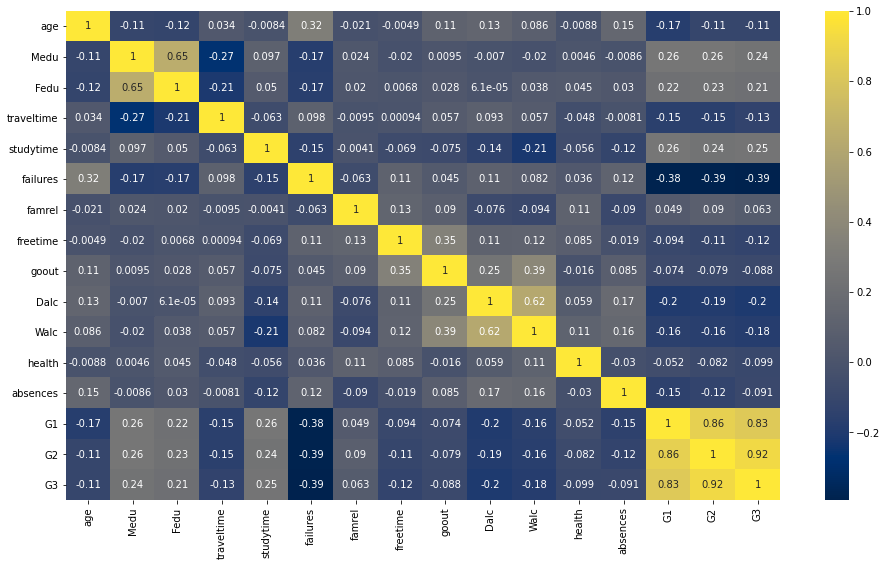

In [ ]:
portData = pd.read_csv('student-por.csv')
print("Portuguese Data Shape:", portData.shape)
plt.figure(figsize=(16, 9))
portCM = portData.corr()
portFeatures = []
for col in portCM['G3'].index:
  if(abs(portCM['G3'][col]) > 0.1):
    portFeatures.append(col)
print("Feature Selection for Portuguese Data:", portFeatures)
sns.heatmap(portCM, annot=True, cmap='cividis')

## Using all features

In [ ]:
portData = pd.read_csv('student-por.csv')
print("Portuguese Data Shape:", portData.shape)
X_test11, y_test11, model_performance11 = modelComparison(portData, 'Portugese Data with one-hot encoding and min-max scaling', 
                                                       encoding = 0, scaling = 0, test = 0.2)
model_performance11

Portuguese Data Shape: (649, 33)
For Portugese Data with one-hot encoding and min-max scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
MinMax Scaled Data Shape: (649, 43)
Train Data: (415, 43) 415
Validation Data: (104, 43) 104
Test Data: (130, 43) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
          

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",53.253012,50.961538,51
1,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,49.397590,50.961538,51
2,Support Vector Machine,"SVC(C=1, break_ties=False, cache_size=200, cla...",48.915663,50.000000,52
3,Neural Network,"MLPClassifier(activation='tanh', alpha=0.1, ba...",50.843373,49.038462,53
4,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.156627,47.115385,55
5,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",51.325301,46.153846,56
6,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",48.192771,46.153846,56
7,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",50.120482,45.192308,57
8,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",52.048193,43.269231,59
9,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",50.843373,42.307692,60


In [ ]:
portData = pd.read_csv('student-por.csv')
print("Portuguese Data Shape:", portData.shape)
X_test12, y_test12, model_performance12 = modelComparison(portData, 'Portugese Data with label encoding and min-max scaling', 
                                                       encoding = 1, scaling = 0, test = 0.2)
model_performance12

Portuguese Data Shape: (649, 33)
For Portugese Data with label encoding and min-max scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
MinMax Scaled Data Shape: (649, 30)
Train Data: (415, 30) 415
Validation Data: (104, 30) 104
Test Data: (130, 30) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
            

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Neural Network,"MLPClassifier(activation='relu', alpha=0.1, ba...",51.325301,52.884615,49
1,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",49.638554,51.923077,50
2,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",49.879518,50.000000,52
3,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.397590,50.000000,52
4,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",50.361446,49.038462,53
5,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",53.012048,48.076923,54
6,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,48.674699,48.076923,54
7,Support Vector Machine,"SVC(C=1, break_ties=False, cache_size=200, cla...",48.915663,47.115385,55
8,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",51.807229,45.192308,57
9,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",51.325301,45.192308,57


In [ ]:
portData = pd.read_csv('student-por.csv')
print("Portuguese Data Shape:", portData.shape)
X_test13, y_test13, model_performance13 = modelComparison(portData, 'Portugese Data with one-hot encoding and standard scaling', 
                                                       encoding = 0, scaling = 1, test = 0.2)
model_performance13

Portuguese Data Shape: (649, 33)
For Portugese Data with one-hot encoding and standard scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Standard Scaled Data Shape: (649, 43)
Train Data: (415, 43) 415
Validation Data: (104, 43) 104
Test Data: (130, 43) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
       

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Neural Network,"MLPClassifier(activation='tanh', alpha=1, batc...",56.867470,49.038462,53
1,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",51.566265,48.076923,54
2,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,49.638554,48.076923,54
3,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.156627,47.115385,55
4,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",47.469880,47.115385,55
5,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",51.566265,46.153846,56
6,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",49.397590,46.153846,56
7,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",49.156627,45.192308,57
8,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",49.156627,44.230769,58
9,Support Vector Machine,"SVC(C=1, break_ties=False, cache_size=200, cla...",48.192771,43.269231,59


In [ ]:
print("Portuguese Data Shape:", portData.shape)
X_test14, y_test14, model_performance14 = modelComparison(portData, 'Portugese Data with label encoding and standard scaling', 
                                                       encoding = 1, scaling = 1, test = 0.2)
model_performance14

Portuguese Data Shape: (649, 38)
For Portugese Data with label encoding and standard scaling
Boolean-category columns: {}
Multi-category columns: {'Mjob': ['Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Standard Scaled Data Shape: (649, 35)
Train Data: (415, 35) 415
Validation Data: (104, 35) 104
Test Data: (130, 35) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
           

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Support Vector Machine,"SVC(C=1, break_ties=False, cache_size=200, cla...",53.012048,50.000000,52
1,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",52.048193,50.000000,52
2,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,51.084337,50.000000,52
3,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.879518,50.000000,52
4,Neural Network,"MLPClassifier(activation='relu', alpha=0.01, b...",53.734940,49.038462,53
5,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",52.530120,48.076923,54
6,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",50.120482,47.115385,55
7,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",49.638554,47.115385,55
8,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",51.084337,46.153846,56
9,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",51.325301,44.230769,58


In [ ]:
portData = pd.read_csv('student-por.csv')
print("Portuguese Data Shape:", portData.shape)
X_test15, y_test15, model_performance15 = modelComparison(portData, 'Portugese Data with one-hot encoding and no scaling', 
                                                       encoding = 0, scaling = 2, test = 0.2)
model_performance15

Portuguese Data Shape: (649, 33)
For Portugese Data with one-hot encoding and no scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Un-Scaled Data Shape: (649, 43)
Train Data: (415, 43) 415
Validation Data: (104, 43) 104
Test Data: (130, 43) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",47.710843,52.884615,49
1,Neural Network,"MLPClassifier(activation='tanh', alpha=1, batc...",53.493976,50.961538,51
2,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",49.156627,50.961538,51
3,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",53.975904,50.000000,52
4,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",50.361446,50.000000,52
5,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",52.771084,49.038462,53
6,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,49.879518,49.038462,53
7,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",53.253012,47.115385,55
8,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",52.771084,46.153846,56
9,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",51.566265,46.153846,56


In [ ]:
portData = pd.read_csv('student-por.csv')
print("Portuguese Data Shape:", portData.shape)
X_test16, y_test16, model_performance16 = modelComparison(portData, 'Portugese Data with label encoding and no scaling', 
                                                       encoding = 1, scaling = 2, test = 0.2)
model_performance16

Portuguese Data Shape: (649, 33)
For Portugese Data with label encoding and no scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Un-Scaled Data Shape: (649, 30)
Train Data: (415, 30) 415
Validation Data: (104, 30) 104
Test Data: (130, 30) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   mu

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",51.325301,51.923077,50
1,Neural Network,"MLPClassifier(activation='tanh', alpha=10, bat...",55.662651,50.961538,51
2,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",53.734940,50.961538,51
3,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",51.084337,50.961538,51
4,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,48.674699,50.961538,51
5,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",47.951807,50.000000,52
6,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",52.048193,49.038462,53
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",50.602410,49.038462,53
8,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",48.915663,49.038462,53
9,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",50.361446,44.230769,58


## Using selected features

In [ ]:
portData = pd.read_csv('student-por.csv')
portDataSelect = portData.loc[:, portFeatures]
print("Portuguese Selected Features Data Shape:", portDataSelect.shape)
X_test21, y_test21, model_performance21 = modelComparison(portDataSelect, 'Portugese Select Data with one-hot encoding and min-max scaling', 
                                                        encoding = 0, scaling = 0, test = 0.2)
model_performance21

Portuguese Selected Features Data Shape: (649, 12)
For Portugese Select Data with one-hot encoding and min-max scaling
Boolean-category columns: {}
Multi-category columns: {}
MinMax Scaled Data Shape: (649, 9)
Train Data: (415, 9) 415
Validation Data: (104, 9) 104
Test Data: (130, 9) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
           

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",49.156627,50.961538,51
1,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.638554,47.115385,55
2,Support Vector Machine,"SVC(C=100, break_ties=False, cache_size=200, c...",49.397590,47.115385,55
3,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",47.710843,47.115385,55
4,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",44.578313,47.115385,55
5,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",46.987952,46.153846,56
6,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,45.060241,46.153846,56
7,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",48.674699,45.192308,57
8,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",46.987952,45.192308,57
9,Neural Network,"MLPClassifier(activation='tanh', alpha=0.0001,...",52.289157,44.230769,58


In [ ]:
portData = pd.read_csv('student-por.csv')
portDataSelect = portData.loc[:, portFeatures]
print("Portuguese Selected Features Data Shape:", portDataSelect.shape)
X_test22, y_test22, model_performance22 = modelComparison(portDataSelect, 'Portugese Select Data with label encoding and min-max scaling', 
                                                       encoding = 1, scaling = 0, test = 0.2)
model_performance22

Portuguese Selected Features Data Shape: (649, 12)
For Portugese Select Data with label encoding and min-max scaling
Boolean-category columns: {}
Multi-category columns: {}
MinMax Scaled Data Shape: (649, 9)
Train Data: (415, 9) 415
Validation Data: (104, 9) 104
Test Data: (130, 9) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
            

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",48.915663,50.961538,51
1,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",45.301205,48.076923,54
2,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.397590,47.115385,55
3,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",47.228916,47.115385,55
4,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",45.060241,47.115385,55
5,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,43.132530,46.153846,56
6,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",50.361446,45.192308,57
7,Support Vector Machine,"SVC(C=10, break_ties=False, cache_size=200, cl...",49.638554,45.192308,57
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",46.265060,45.192308,57
9,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",48.915663,44.230769,58


In [ ]:
portData = pd.read_csv('student-por.csv')
portDataSelect = portData.loc[:, portFeatures]
print("Portuguese Selected Features Data Shape:", portDataSelect.shape)
X_test23, y_test23, model_performance23 = modelComparison(portDataSelect, 'Portugese Select Data with one-hot encoding and standard scaling', 
                                                       encoding = 0, scaling = 1, test = 0.2)
model_performance23

Portuguese Selected Features Data Shape: (649, 12)
For Portugese Select Data with one-hot encoding and standard scaling
Boolean-category columns: {}
Multi-category columns: {}
Standard Scaled Data Shape: (649, 9)
Train Data: (415, 9) 415
Validation Data: (104, 9) 104
Test Data: (130, 9) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
       

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",50.843373,50.961538,51
1,Neural Network,"MLPClassifier(activation='tanh', alpha=1, batc...",49.879518,48.076923,54
2,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",48.674699,47.115385,55
3,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",46.506024,47.115385,55
4,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,50.361446,46.153846,56
5,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",48.433735,46.153846,56
6,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",47.951807,46.153846,56
7,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",51.084337,45.192308,57
8,Support Vector Machine,"SVC(C=10, break_ties=False, cache_size=200, cl...",48.915663,45.192308,57
9,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",48.915663,44.230769,58


In [ ]:
portData = pd.read_csv('student-por.csv')
portDataSelect = portData.loc[:, portFeatures]
print("Portuguese Selected Features Data Shape:", portDataSelect.shape)
X_test24, y_test24, model_performance24 = modelComparison(portDataSelect, 'Portugese Select Data with label encoding and standard scaling', 
                                                       encoding = 1, scaling = 1, test = 0.2)
model_performance24

Portuguese Selected Features Data Shape: (649, 12)
For Portugese Select Data with label encoding and standard scaling
Boolean-category columns: {}
Multi-category columns: {}
Standard Scaled Data Shape: (649, 9)
Train Data: (415, 9) 415
Validation Data: (104, 9) 104
Test Data: (130, 9) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
          

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",46.746988,50.961538,51
1,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",51.084337,47.115385,55
2,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",50.120482,47.115385,55
3,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",49.879518,46.153846,56
4,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",49.397590,46.153846,56
5,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,46.987952,46.153846,56
6,Support Vector Machine,"SVC(C=10, break_ties=False, cache_size=200, cl...",49.156627,45.192308,57
7,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",49.156627,44.230769,58
8,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='ball_tree', le...",47.469880,44.230769,58
9,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",45.542169,44.230769,58


In [ ]:
portData = pd.read_csv('student-por.csv')
portDataSelect = portData.loc[:, portFeatures]
print("Portuguese Selected Features Data Shape:", portDataSelect.shape)
X_test25, y_test25, model_performance25 = modelComparison(portDataSelect, 'Portugese Select Data with one-hot encoding and no scaling', 
                                                       encoding = 0, scaling = 2, test = 0.2)
model_performance25

Portuguese Selected Features Data Shape: (649, 12)
For Portugese Select Data with one-hot encoding and no scaling
Boolean-category columns: {}
Multi-category columns: {}
Un-Scaled Data Shape: (649, 9)
Train Data: (415, 9) 415
Validation Data: (104, 9) 104
Test Data: (130, 9) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l2', power_t=0

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Neural Network,"MLPClassifier(activation='tanh', alpha=0.01, b...",52.048193,48.076923,54
1,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",50.120482,47.115385,55
2,Support Vector Machine,"SVC(C=100, break_ties=False, cache_size=200, c...",49.638554,47.115385,55
3,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",46.506024,47.115385,55
4,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,49.879518,46.153846,56
5,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",49.638554,46.153846,56
6,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='brute', leaf_s...",45.301205,46.153846,56
7,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",44.819277,45.192308,57
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",50.602410,44.230769,58
9,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",47.469880,44.230769,58


In [ ]:
portData = pd.read_csv('student-por.csv')
portDataSelect = portData.loc[:, portFeatures]
print("Portuguese Selected Features Data Shape:", portDataSelect.shape)
X_test26, y_test26, model_performance26 = modelComparison(portDataSelect, 'Portugese Select Data with label encoding and no scaling', 
                                                       encoding = 1, scaling = 2, test = 0.2)
model_performance26

Portuguese Selected Features Data Shape: (649, 12)
For Portugese Select Data with label encoding and no scaling
Boolean-category columns: {}
Multi-category columns: {}
Un-Scaled Data Shape: (649, 9)
Train Data: (415, 9) 415
Validation Data: (104, 9) 104
Test Data: (130, 9) 130
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",47.228916,47.115385,55
1,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='ball_tree', le...",46.987952,47.115385,55
2,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",45.542169,47.115385,55
3,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",53.012048,46.153846,56
4,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",48.915663,46.153846,56
5,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,47.710843,46.153846,56
6,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",49.397590,45.192308,57
7,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",46.987952,45.192308,57
8,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",46.987952,45.192308,57
9,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",49.156627,44.230769,58


# Math Data

Math Data Shape: (395, 33)
Feature Selection for Math Data: ['age', 'Medu', 'Fedu', 'traveltime', 'failures', 'goout', 'G1', 'G2', 'G3']


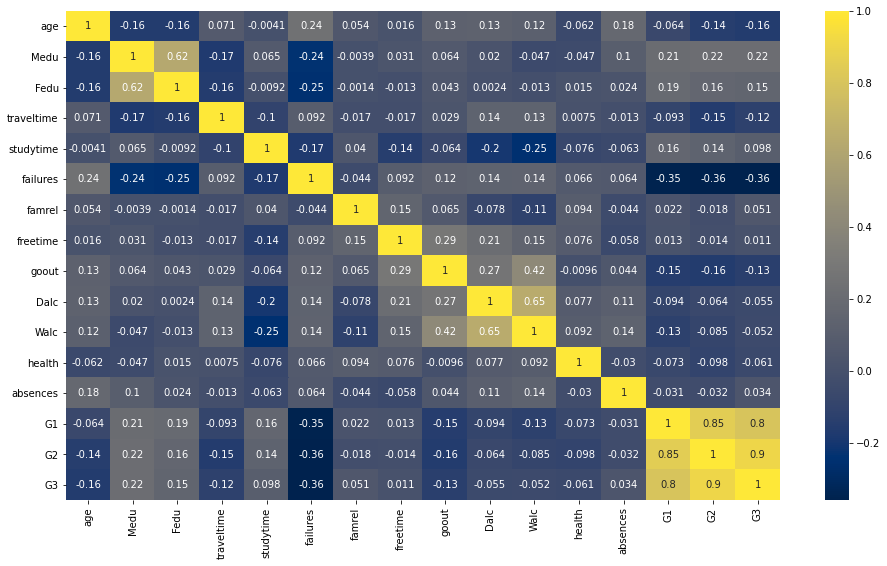

In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
plt.figure(figsize=(16, 9))
mathCM = mathData.corr()
sns.heatmap(mathCM, annot=True, cmap='cividis')
mathFeatures = []
for col in mathCM['G3'].index:
  if(abs(mathCM['G3'][col]) > 0.1):
    mathFeatures.append(col)
print("Feature Selection for Math Data:", mathFeatures)

## Using all features

In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
X_test31, y_test31, model_performance31 = modelComparison(mathData, 'Math Data with one-hot encoding and min-max scaling', 
                                                       encoding = 0, scaling = 0, test = 0.2)
model_performance31

Math Data Shape: (395, 33)
For Math Data with one-hot encoding and min-max scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
MinMax Scaled Data Shape: (395, 43)
Train Data: (252, 43) 252
Validation Data: (64, 43) 64
Test Data: (79, 43) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",59.607843,64.0625,23
1,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,59.215686,64.0625,23
2,Neural Network,"MLPClassifier(activation='tanh', alpha=0.001, ...",59.215686,60.9375,25
3,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",54.509804,60.9375,25
4,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
5,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
6,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
7,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.823529,59.3750,26
8,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
9,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",58.823529,59.3750,26


In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
X_test32, y_test32, model_performance32 = modelComparison(mathData, 'Math Data with label encoding and min-max scaling', 
                                                       encoding = 1, scaling = 0, test = 0.2)
model_performance32

Math Data Shape: (395, 33)
For Math Data with label encoding and min-max scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
MinMax Scaled Data Shape: (395, 30)
Train Data: (252, 30) 252
Validation Data: (64, 30) 64
Test Data: (79, 30) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_cl

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",61.568627,65.6250,22
1,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,60.000000,65.6250,22
2,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",54.509804,60.9375,25
3,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",47.843137,60.9375,25
4,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",60.784314,59.3750,26
5,Neural Network,"MLPClassifier(activation='relu', alpha=10, bat...",59.607843,59.3750,26
6,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
7,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
8,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
9,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26


In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
X_test33, y_test33, model_performance33 = modelComparison(mathData, 'Math Data with one-hot encoding and standard scaling', 
                                                       encoding = 0, scaling = 1, test = 0.2)
model_performance33

Math Data Shape: (395, 33)
For Math Data with one-hot encoding and standard scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Standard Scaled Data Shape: (395, 43)
Train Data: (252, 43) 252
Validation Data: (64, 43) 64
Test Data: (79, 43) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   mul

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,59.215686,64.0625,23
1,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",60.784314,60.9375,25
2,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",60.392157,60.9375,25
3,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,60.9375,25
4,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",56.862745,60.9375,25
5,Neural Network,"MLPClassifier(activation='tanh', alpha=0.0001,...",59.215686,59.3750,26
6,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
7,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
8,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.823529,59.3750,26
9,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26


In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
X_test34, y_test34, model_performance34 = modelComparison(mathData, 'Math Data with label encoding and standard scaling', 
                                                       encoding = 1, scaling = 1, test = 0.2)
model_performance34

Math Data Shape: (395, 33)
For Math Data with label encoding and standard scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Standard Scaled Data Shape: (395, 30)
Train Data: (252, 30) 252
Validation Data: (64, 30) 64
Test Data: (79, 30) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",61.176471,64.0625,23
1,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",56.470588,60.9375,25
2,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",46.274510,60.9375,25
3,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",61.176471,59.3750,26
4,Neural Network,"MLPClassifier(activation='tanh', alpha=0.0001,...",59.215686,59.3750,26
5,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
6,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
8,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",57.647059,59.3750,26
9,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",59.215686,56.2500,28


In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
X_test35, y_test35, model_performance35 = modelComparison(mathData, 'Math Data with one-hot encoding and no scaling', 
                                                       encoding = 0, scaling = 2, test = 0.2)
model_performance35

Math Data Shape: (395, 33)
For Math Data with one-hot encoding and no scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Un-Scaled Data Shape: (395, 43)
Train Data: (252, 43) 252
Validation Data: (64, 43) 64
Test Data: (79, 43) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='au

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",60.392157,64.0625,23
1,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,58.431373,64.0625,23
2,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",55.686275,60.9375,25
3,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",60.392157,59.3750,26
4,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",59.215686,59.3750,26
5,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",59.215686,59.3750,26
6,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
7,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
8,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
9,Neural Network,"MLPClassifier(activation='relu', alpha=1, batc...",60.000000,57.8125,27


In [ ]:
mathData = pd.read_csv('student-mat.csv')
print("Math Data Shape:", mathData.shape)
X_test36, y_test36, model_performance36 = modelComparison(mathData, 'Math Data with label encoding and no scaling', 
                                                       encoding = 1, scaling = 2, test = 0.2)
model_performance36

Math Data Shape: (395, 33)
For Math Data with label encoding and no scaling
Boolean-category columns: {'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['U', 'R'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'schoolsup': ['yes', 'no'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['yes', 'no'], 'higher': ['yes', 'no'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
Multi-category columns: {'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'], 'reason': ['course', 'other', 'home', 'reputation'], 'guardian': ['mother', 'father', 'other']}
Un-Scaled Data Shape: (395, 30)
Train Data: (252, 30) 252
Validation Data: (64, 30) 64
Test Data: (79, 30) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,61.568627,65.6250,22
1,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",59.215686,64.0625,23
2,Neural Network,"MLPClassifier(activation='tanh', alpha=10, bat...",60.000000,62.5000,24
3,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",49.803922,60.9375,25
4,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
5,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
6,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",58.823529,59.3750,26
9,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.039216,57.8125,27


## Using selected features

In [ ]:
mathData = pd.read_csv('student-mat.csv')
mathDataSelect = mathData.loc[:, mathFeatures]
print("Math Selected Features Data Shape:", mathDataSelect.shape)
X_test41, y_test41, model_performance41 = modelComparison(mathDataSelect, 'Math Select Data with one-hot encoding and min-max scaling', 
                                                       encoding = 0, scaling = 0, test = 0.2)
model_performance41

Math Selected Features Data Shape: (395, 9)
For Math Select Data with one-hot encoding and min-max scaling
Boolean-category columns: {}
Multi-category columns: {}
MinMax Scaled Data Shape: (395, 6)
Train Data: (252, 6) 252
Validation Data: (64, 6) 64
Test Data: (79, 6) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l2', power_t=0.5

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Neural Network,"MLPClassifier(activation='relu', alpha=1, batc...",60.392157,62.5000,24
1,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",58.823529,62.5000,24
2,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",58.823529,60.9375,25
3,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
4,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
5,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
6,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.823529,59.3750,26
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",58.823529,59.3750,26
9,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,54.509804,56.2500,28


In [ ]:
mathData = pd.read_csv('student-mat.csv')
mathDataSelect = mathData.loc[:, mathFeatures]
print("Math Selected Features Data Shape:", mathDataSelect.shape)
X_test42, y_test42, model_performance42 = modelComparison(mathDataSelect, 'Math Select Data with label encoding and min-max scaling', 
                                                       encoding = 1, scaling = 0, test = 0.2)
model_performance42

Math Selected Features Data Shape: (395, 9)
For Math Select Data with label encoding and min-max scaling
Boolean-category columns: {}
Multi-category columns: {}
MinMax Scaled Data Shape: (395, 6)
Train Data: (252, 6) 252
Validation Data: (64, 6) 64
Test Data: (79, 6) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l2', power_t=0.5, 

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",59.215686,62.5000,24
1,Neural Network,"MLPClassifier(activation='relu', alpha=1, batc...",60.392157,60.9375,25
2,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",58.823529,60.9375,25
3,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
4,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
5,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
6,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.823529,59.3750,26
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",60.000000,57.8125,27
9,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,52.941176,56.2500,28


In [ ]:
mathData = pd.read_csv('student-mat.csv')
mathDataSelect = mathData.loc[:, mathFeatures]
print("Math Selected Features Data Shape:", mathDataSelect.shape)
X_test43, y_test43, model_performance43 = modelComparison(mathDataSelect, 'Math Select Data with one-hot encoding and standard scaling', 
                                                       encoding = 0, scaling = 1, test = 0.2)
model_performance43

Math Selected Features Data Shape: (395, 9)
For Math Select Data with one-hot encoding and standard scaling
Boolean-category columns: {}
Multi-category columns: {}
Standard Scaled Data Shape: (395, 6)
Train Data: (252, 6) 252
Validation Data: (64, 6) 64
Test Data: (79, 6) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",60.000000,62.5000,24
1,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",59.607843,62.5000,24
2,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",59.607843,60.9375,25
3,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",59.607843,60.9375,25
4,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",58.823529,60.9375,25
5,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.823529,59.3750,26
6,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
7,Neural Network,"MLPClassifier(activation='tanh', alpha=0.0001,...",58.823529,59.3750,26
8,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",58.823529,59.3750,26
9,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,55.686275,56.2500,28


In [ ]:
mathData = pd.read_csv('student-mat.csv')
mathDataSelect = mathData.loc[:, mathFeatures]
print("Math Selected Features Data Shape:", mathDataSelect.shape)
X_test44, y_test44, model_performance44 = modelComparison(mathDataSelect, 'Math Select Data with label encoding and standard scaling', 
                                                       encoding = 1, scaling = 1, test = 0.2)
model_performance44

Math Selected Features Data Shape: (395, 9)
For Math Select Data with label encoding and standard scaling
Boolean-category columns: {}
Multi-category columns: {}
Standard Scaled Data Shape: (395, 6)
Train Data: (252, 6) 252
Validation Data: (64, 6) 64
Test Data: (79, 6) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l2', power_t=0.

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",58.431373,62.5000,24
1,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",58.823529,60.9375,25
2,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",58.823529,59.3750,26
3,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
4,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",58.823529,59.3750,26
5,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",58.823529,59.3750,26
6,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
7,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",60.000000,57.8125,27
8,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,52.156863,56.2500,28
9,Neural Network,"MLPClassifier(activation='relu', alpha=0.01, b...",60.392157,54.6875,29


In [ ]:
mathData = pd.read_csv('student-mat.csv')
mathDataSelect = mathData.loc[:, mathFeatures]
print("Math Selected Features Data Shape:", mathDataSelect.shape)
X_test45, y_test45, model_performance45 = modelComparison(mathDataSelect, 'Math Select Data with one-hot encoding and no scaling', 
                                                       encoding = 0, scaling = 2, test = 0.2)
model_performance45

Math Selected Features Data Shape: (395, 9)
For Math Select Data with one-hot encoding and no scaling
Boolean-category columns: {}
Multi-category columns: {}
Un-Scaled Data Shape: (395, 6)
Train Data: (252, 6) 252
Validation Data: (64, 6) 64
Test Data: (79, 6) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Neural Network,"MLPClassifier(activation='relu', alpha=0.001, ...",60.000000,62.5000,24
1,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",59.215686,62.5000,24
2,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",58.823529,62.5000,24
3,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='brute', leaf_s...",61.176471,60.9375,25
4,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",59.607843,60.9375,25
5,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",59.215686,60.9375,25
6,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",59.215686,59.3750,26
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
8,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,55.686275,56.2500,28
9,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",50.196078,54.6875,29


In [ ]:
mathData = pd.read_csv('student-mat.csv')
mathDataSelect = mathData.loc[:, mathFeatures]
print("Math Selected Features Data Shape:", mathDataSelect.shape)
X_test46, y_test46, model_performance46 = modelComparison(mathDataSelect, 'Math Select Data with label encoding and no scaling', 
                                                       encoding = 1, scaling = 2, test = 0.2)
model_performance46

Math Selected Features Data Shape: (395, 9)
For Math Select Data with label encoding and no scaling
Boolean-category columns: {}
Multi-category columns: {}
Un-Scaled Data Shape: (395, 6)
Train Data: (252, 6) 252
Validation Data: (64, 6) 64
Test Data: (79, 6) 79
Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=750,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=No

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples
0,Neural Network,"MLPClassifier(activation='tanh', alpha=1, batc...",60.000000,62.5000,24
1,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",58.431373,62.5000,24
2,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",57.647059,62.5000,24
3,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",59.215686,60.9375,25
4,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='ball_tree', le...",59.215686,60.9375,25
5,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",60.000000,59.3750,26
6,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",58.823529,59.3750,26
7,Support Vector Machine,"SVC(C=0.1, break_ties=False, cache_size=200, c...",58.823529,59.3750,26
8,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,52.549020,56.2500,28
9,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",48.235294,54.6875,29


# Results

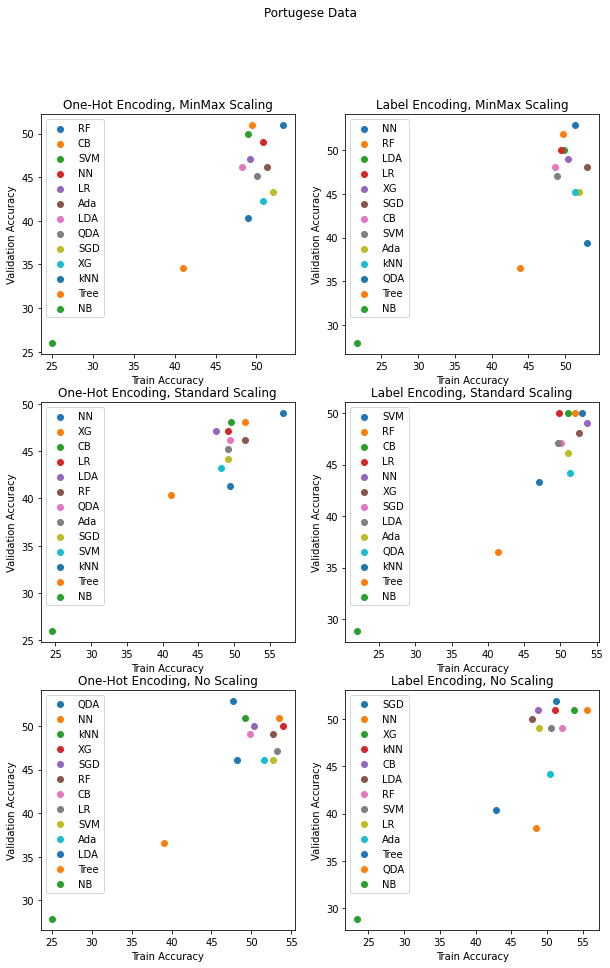

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 15)
model_abbr = {'Logistic Regression': 'LR', 'Stochastic Gradient Descent': 'SGD', 'Decision Tree': 'Tree', 'Random Forest': 'RF', 
              'AdaBoot': 'Ada', 'k-Nearest Neighbors': 'kNN', 'Linear Discriminant Analysis': 'LDA', 'Quadratic Discriminant Analysis': 'QDA', 
              'Naive-Bayes': 'NB', 'Support Vector Machine': 'SVM', 'Neural Network': 'NN', 'XGBoost': 'XG', 'CatBoost': 'CB'}
for idx in range(len(model_abbr)):
  axs[0, 0].scatter(model_performance11.loc[idx, 'Train Accuracy'], model_performance11.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance11.loc[idx, 'Abbr']])
  axs[0, 1].scatter(model_performance12.loc[idx, 'Train Accuracy'], model_performance12.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance12.loc[idx, 'Abbr']])
  axs[1, 0].scatter(model_performance13.loc[idx, 'Train Accuracy'], model_performance13.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance13.loc[idx, 'Abbr']])
  axs[1, 1].scatter(model_performance14.loc[idx, 'Train Accuracy'], model_performance14.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance14.loc[idx, 'Abbr']])
  axs[2, 0].scatter(model_performance15.loc[idx, 'Train Accuracy'], model_performance15.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance15.loc[idx, 'Abbr']])
  axs[2, 1].scatter(model_performance16.loc[idx, 'Train Accuracy'], model_performance16.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance16.loc[idx, 'Abbr']])
axs[0, 0].set_title('One-Hot Encoding, MinMax Scaling')
axs[0, 0].legend()
axs[0, 1].set_title('Label Encoding, MinMax Scaling')
axs[0, 1].legend()
axs[1, 0].set_title('One-Hot Encoding, Standard Scaling')
axs[1, 0].legend()
axs[1, 1].set_title('Label Encoding, Standard Scaling')
axs[1, 1].legend()
axs[2, 0].set_title('One-Hot Encoding, No Scaling')
axs[2, 0].legend()
axs[2, 1].set_title('Label Encoding, No Scaling')
axs[2, 1].legend()
fig.suptitle('Portugese Data')
for ax in axs.flat:
    ax.set(xlabel='Train Accuracy', ylabel='Validation Accuracy')
fig.show()

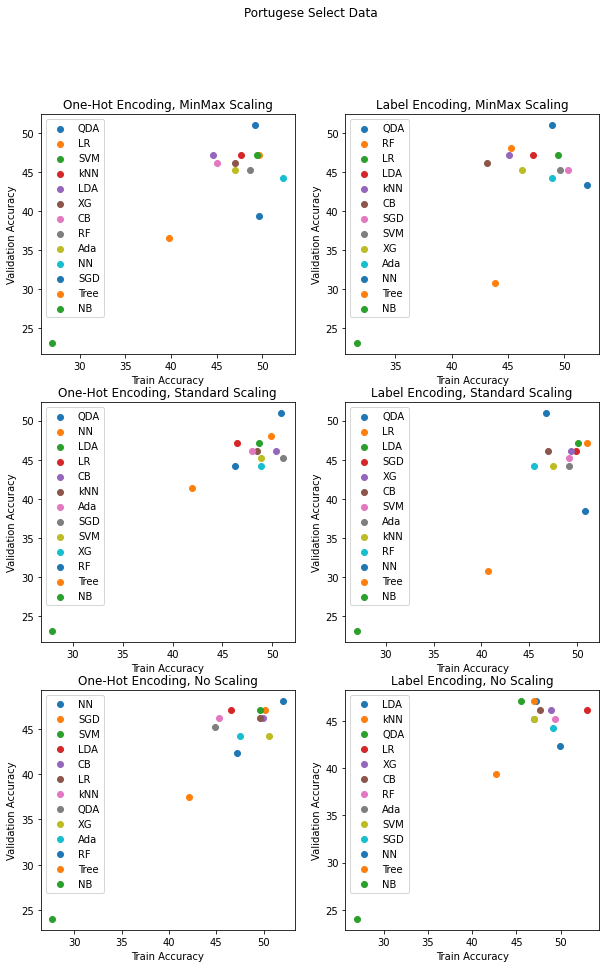

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 15)
model_abbr = {'Logistic Regression': 'LR', 'Stochastic Gradient Descent': 'SGD', 'Decision Tree': 'Tree', 'Random Forest': 'RF', 
              'AdaBoot': 'Ada', 'k-Nearest Neighbors': 'kNN', 'Linear Discriminant Analysis': 'LDA', 'Quadratic Discriminant Analysis': 'QDA', 
              'Naive-Bayes': 'NB', 'Support Vector Machine': 'SVM', 'Neural Network': 'NN', 'XGBoost': 'XG', 'CatBoost': 'CB'}
for idx in range(len(model_abbr)):
  axs[0, 0].scatter(model_performance21.loc[idx, 'Train Accuracy'], model_performance21.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance21.loc[idx, 'Abbr']])
  axs[0, 1].scatter(model_performance22.loc[idx, 'Train Accuracy'], model_performance22.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance22.loc[idx, 'Abbr']])
  axs[1, 0].scatter(model_performance23.loc[idx, 'Train Accuracy'], model_performance23.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance23.loc[idx, 'Abbr']])
  axs[1, 1].scatter(model_performance24.loc[idx, 'Train Accuracy'], model_performance24.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance24.loc[idx, 'Abbr']])
  axs[2, 0].scatter(model_performance25.loc[idx, 'Train Accuracy'], model_performance25.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance25.loc[idx, 'Abbr']])
  axs[2, 1].scatter(model_performance26.loc[idx, 'Train Accuracy'], model_performance26.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance26.loc[idx, 'Abbr']])
axs[0, 0].set_title('One-Hot Encoding, MinMax Scaling')
axs[0, 0].legend()
axs[0, 1].set_title('Label Encoding, MinMax Scaling')
axs[0, 1].legend()
axs[1, 0].set_title('One-Hot Encoding, Standard Scaling')
axs[1, 0].legend()
axs[1, 1].set_title('Label Encoding, Standard Scaling')
axs[1, 1].legend()
axs[2, 0].set_title('One-Hot Encoding, No Scaling')
axs[2, 0].legend()
axs[2, 1].set_title('Label Encoding, No Scaling')
axs[2, 1].legend()
fig.suptitle('Portugese Select Data')
for ax in axs.flat:
    ax.set(xlabel='Train Accuracy', ylabel='Validation Accuracy')
fig.show()

In [ ]:
model_performance11['Dataset'] = 11
model_performance12['Dataset'] = 12
model_performance13['Dataset'] = 13
model_performance14['Dataset'] = 14
model_performance15['Dataset'] = 15
model_performance16['Dataset'] = 16
model_performance21['Dataset'] = 21
model_performance22['Dataset'] = 22
model_performance23['Dataset'] = 23
model_performance24['Dataset'] = 24
model_performance25['Dataset'] = 25
model_performance26['Dataset'] = 26
portDF = [model_performance11, model_performance12, model_performance13, model_performance14, model_performance15, model_performance16,
          model_performance21, model_performance22, model_performance23, model_performance24, model_performance25, model_performance26]

#concatenate dataframes
portModels = pd.concat(portDF, sort=False)
portModels = portModels.sort_values(by=['Validation Accuracy', 'Train Accuracy'], ascending=False)
portModels = portModels.reset_index(drop = True)
portModels.to_csv('PortugeseModels.csv', index = False)
portModels

,Abbr,Model,Train Accuracy,Validation Accuracy,Misclassified Samples,Dataset
0,Neural Network,"MLPClassifier(activation='relu', alpha=0.1, ba...",51.325301,52.884615,49,12
1,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",47.710843,52.884615,49,15
2,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",51.325301,51.923077,50,16
3,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",49.638554,51.923077,50,12
4,Neural Network,"MLPClassifier(activation='tanh', alpha=10, bat...",55.662651,50.961538,51,16
...,...,...,...,...,...,...
151,Naive-Bayes,"GaussianNB(priors=None, var_smoothing=1e-09)",26.987952,24.038462,79,26
152,Naive-Bayes,"GaussianNB(priors=None, var_smoothing=1e-09)",31.566265,23.076923,80,22
153,Naive-Bayes,"GaussianNB(priors=None, var_smoothing=1e-09)",27.951807,23.076923,80,23
154,Naive-Bayes,"GaussianNB(priors=None, var_smoothing=1e-09)",26.987952,23.076923,80,21


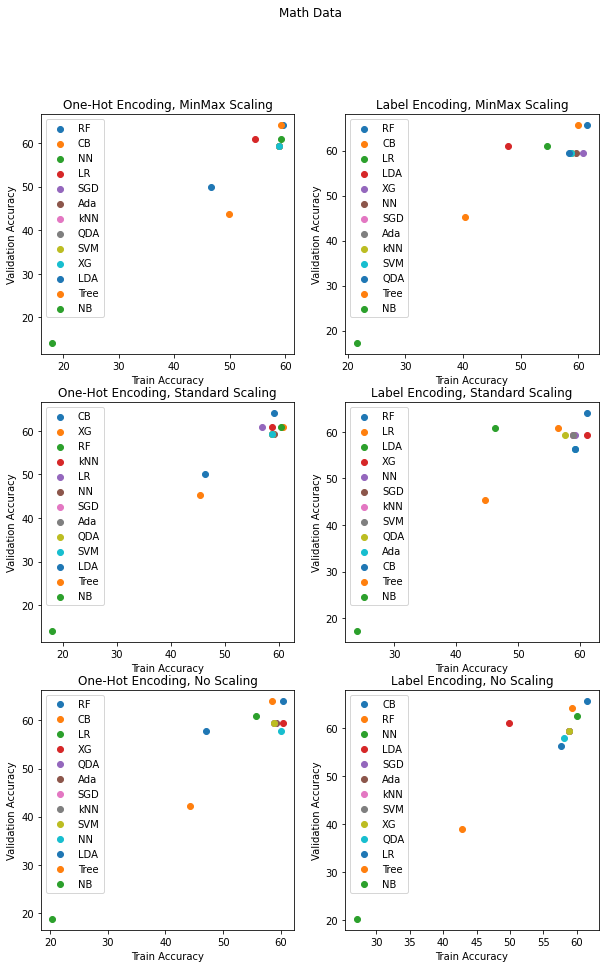

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 15)
model_abbr = {'Logistic Regression': 'LR', 'Stochastic Gradient Descent': 'SGD', 'Decision Tree': 'Tree', 'Random Forest': 'RF', 
              'AdaBoot': 'Ada', 'k-Nearest Neighbors': 'kNN', 'Linear Discriminant Analysis': 'LDA', 'Quadratic Discriminant Analysis': 'QDA', 
              'Naive-Bayes': 'NB', 'Support Vector Machine': 'SVM', 'Neural Network': 'NN', 'XGBoost': 'XG', 'CatBoost': 'CB'}
for idx in range(len(model_abbr)):
  axs[0, 0].scatter(model_performance31.loc[idx, 'Train Accuracy'], model_performance31.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance31.loc[idx, 'Abbr']])
  axs[0, 1].scatter(model_performance32.loc[idx, 'Train Accuracy'], model_performance32.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance32.loc[idx, 'Abbr']])
  axs[1, 0].scatter(model_performance33.loc[idx, 'Train Accuracy'], model_performance33.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance33.loc[idx, 'Abbr']])
  axs[1, 1].scatter(model_performance34.loc[idx, 'Train Accuracy'], model_performance34.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance34.loc[idx, 'Abbr']])
  axs[2, 0].scatter(model_performance35.loc[idx, 'Train Accuracy'], model_performance35.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance35.loc[idx, 'Abbr']])
  axs[2, 1].scatter(model_performance36.loc[idx, 'Train Accuracy'], model_performance36.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance36.loc[idx, 'Abbr']])
axs[0, 0].set_title('One-Hot Encoding, MinMax Scaling')
axs[0, 0].legend()
axs[0, 1].set_title('Label Encoding, MinMax Scaling')
axs[0, 1].legend()
axs[1, 0].set_title('One-Hot Encoding, Standard Scaling')
axs[1, 0].legend()
axs[1, 1].set_title('Label Encoding, Standard Scaling')
axs[1, 1].legend()
axs[2, 0].set_title('One-Hot Encoding, No Scaling')
axs[2, 0].legend()
axs[2, 1].set_title('Label Encoding, No Scaling')
axs[2, 1].legend()
fig.suptitle('Math Data')
for ax in axs.flat:
    ax.set(xlabel='Train Accuracy', ylabel='Validation Accuracy')
fig.show()

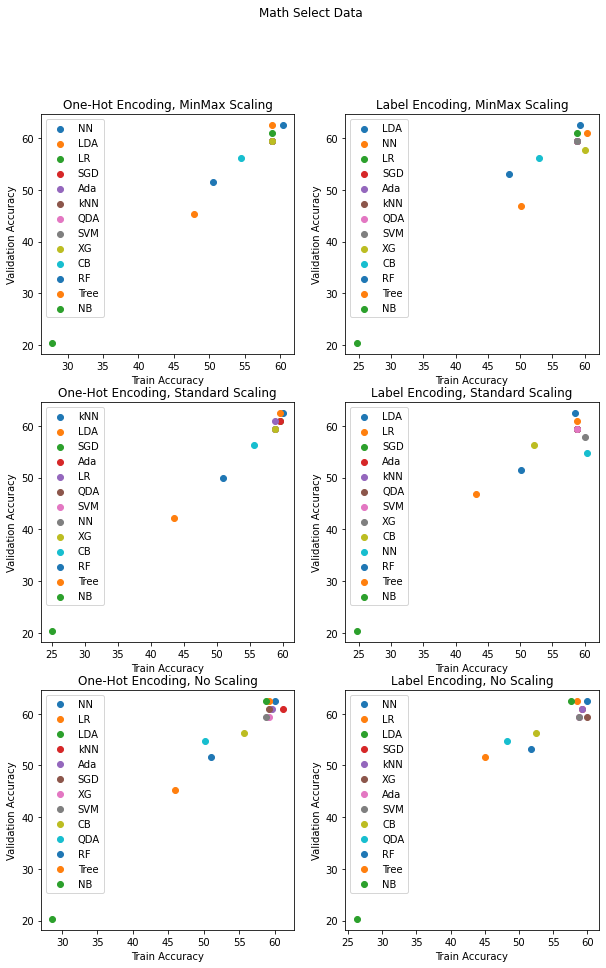

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 15)
model_abbr = {'Logistic Regression': 'LR', 'Stochastic Gradient Descent': 'SGD', 'Decision Tree': 'Tree', 'Random Forest': 'RF', 
              'AdaBoot': 'Ada', 'k-Nearest Neighbors': 'kNN', 'Linear Discriminant Analysis': 'LDA', 'Quadratic Discriminant Analysis': 'QDA', 
              'Naive-Bayes': 'NB', 'Support Vector Machine': 'SVM', 'Neural Network': 'NN', 'XGBoost': 'XG', 'CatBoost': 'CB'}
for idx in range(len(model_abbr)):
  axs[0, 0].scatter(model_performance41.loc[idx, 'Train Accuracy'], model_performance41.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance41.loc[idx, 'Abbr']])
  axs[0, 1].scatter(model_performance42.loc[idx, 'Train Accuracy'], model_performance42.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance42.loc[idx, 'Abbr']])
  axs[1, 0].scatter(model_performance43.loc[idx, 'Train Accuracy'], model_performance43.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance43.loc[idx, 'Abbr']])
  axs[1, 1].scatter(model_performance44.loc[idx, 'Train Accuracy'], model_performance44.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance44.loc[idx, 'Abbr']])
  axs[2, 0].scatter(model_performance45.loc[idx, 'Train Accuracy'], model_performance45.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance45.loc[idx, 'Abbr']])
  axs[2, 1].scatter(model_performance46.loc[idx, 'Train Accuracy'], model_performance46.loc[idx, 'Validation Accuracy'], 
  label = model_abbr[model_performance46.loc[idx, 'Abbr']])
axs[0, 0].set_title('One-Hot Encoding, MinMax Scaling')
axs[0, 0].legend()
axs[0, 1].set_title('Label Encoding, MinMax Scaling')
axs[0, 1].legend()
axs[1, 0].set_title('One-Hot Encoding, Standard Scaling')
axs[1, 0].legend()
axs[1, 1].set_title('Label Encoding, Standard Scaling')
axs[1, 1].legend()
axs[2, 0].set_title('One-Hot Encoding, No Scaling')
axs[2, 0].legend()
axs[2, 1].set_title('Label Encoding, No Scaling')
axs[2, 1].legend()
fig.suptitle('Math Select Data')
for ax in axs.flat:
    ax.set(xlabel='Train Accuracy', ylabel='Validation Accuracy')
fig.show()

In [ ]:
model_performance31['Dataset'] = 31
model_performance32['Dataset'] = 32
model_performance33['Dataset'] = 33
model_performance34['Dataset'] = 34
model_performance35['Dataset'] = 35
model_performance36['Dataset'] = 36
model_performance41['Dataset'] = 41
model_performance42['Dataset'] = 42
model_performance43['Dataset'] = 43
model_performance44['Dataset'] = 44
model_performance45['Dataset'] = 45
model_performance46['Dataset'] = 46
mathDF = [model_performance31, model_performance32, model_performance33, model_performance34, model_performance35, model_performance36,
          model_performance41, model_performance42, model_performance43, model_performance44, model_performance45, model_performance46]

#concatenate dataframes
mathModels = pd.concat(mathDF, sort=False)
mathModels = mathModels.sort_values(by=['Validation Accuracy', 'Train Accuracy'], ascending=False)
mathModels = mathModels.reset_index(drop = True)
mathModels.to_csv('MathModels.csv', index = False)
mathModels

In [ ]:
portEstimator = portModels.loc[0, 'Model']
portName = portModels.loc[0, 'Abbr']
n = portModels['Dataset']
y_pred = portEstimator.predict(X_test12)
acc = accuracy_score(y_test12, y_pred)*100
print("Best Model for Portgese Data is "+portName+" with one-hot encoding and standard scaling.\nAccuracy = "+str(acc))

Best Model for Portgese Data is Neural Network with one-hot encoding and standard scaling.
Accuracy = 50.76923076923077


In [ ]:
mathEstimator = mathModels.loc[0, 'Model']
mathName = mathModels.loc[0, 'Abbr']
y_pred = mathEstimator.predict(X_test36)
acc = accuracy_score(y_test36, y_pred)*100
print("Best Model for Portgese Data is "+mathName+" with label encoding and standard scaling.\nAccuracy = "+str(acc))

Best Model for Portgese Data is Random Forest with label encoding and standard scaling.
Accuracy = 62.0253164556962
